# Kaggle 範例

## 郭耀仁

## 課程內容

- House Prices: Advanced Regression Techniques
- Digit Recognizer
- Titanic: Machine Learning from Disaster

# House Prices: Advanced Regression Techniques

## 簡介

> Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.
With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

> Submissions are evaluated on Root-Mean-Squared-Error (RMSE).

## 載入需要的模組

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## 資料載入

In [2]:
train_url = "https://storage.googleapis.com/py_ml_datasets/house_prices/train.csv"
test_url = "https://storage.googleapis.com/py_ml_datasets/house_prices/test.csv"
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

## 資料外觀

In [3]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
all_data = pd.concat(
    [train.loc[:, 'MSSubClass':'SaleCondition'], test.loc[:, 'MSSubClass':'SaleCondition']], axis = 0
)
all_data.shape

(2919, 79)

## 資料外觀（2）

- 79 個變數中有 25 個整數型別、11 個浮點數型別與 43 個文字型別

In [7]:
import numpy as np

np.unique(all_data.dtypes.values, return_counts = True)

(array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object),
 array([25, 11, 43]))

In [8]:
all_data.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1420
GarageType        157
GarageYrBlt       159
GarageFinish      159
GarageCars          1
GarageArea          1
GarageQual        159
GarageCond

In [9]:
total_missing = all_data.isnull().sum().sort_values(ascending=False)
missing_percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, missing_percent], axis = 1, keys = ['Total Missing', 'Missing Percent'])
missing_data.head(20)

,Total Missing,Missing Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


## 特徵工程

- 刪除遺失比例過高的變數（Top 5）
- Log Transform（\* 重要的特徵工程）
- 轉換類別型變數為數值（One-hot encoding）
- 將遺失值以中位數填補

In [10]:
all_data = all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1)
train["SalePrice"] = np.log1p(train["SalePrice"])
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [11]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.median())
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [12]:
all_data.isnull().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
YearRemodAdd             0
MasVnrArea               0
BsmtFinSF1               0
BsmtFinSF2               0
BsmtUnfSF                0
TotalBsmtSF              0
1stFlrSF                 0
2ndFlrSF                 0
LowQualFinSF             0
GrLivArea                0
BsmtFullBath             0
BsmtHalfBath             0
FullBath                 0
HalfBath                 0
BedroomAbvGr             0
KitchenAbvGr             0
TotRmsAbvGrd             0
Fireplaces               0
GarageYrBlt              0
GarageCars               0
GarageArea               0
WoodDeckSF               0
OpenPorchSF              0
EnclosedPorch            0
                        ..
GarageFinish_RFn         0
GarageFinish_Unf         0
GarageQual_Ex            0
GarageQual_Fa            0
GarageQual_Gd            0
GarageQual_Po            0
G

In [13]:
# 整理模型的輸入
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice

## 模型

- Linear Regression
- Ridge
- Lasso
- ElasticNet

In [14]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()
models = [lr, ridge, lasso, elasticnet]
model_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]

def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

for model_name, model in zip(model_names, models):
    print("%s: %f" % (model_name, get_rmse(model)))

Linear Regression: 0.132631
Ridge: 0.126254
Lasso: 0.267405
Elastic Net: 0.263622


## 模型（2）

- 在 Ridge 中尋找合適的 `alpha`

In [15]:
# get_rmse_with_alpha
def get_rmse_with_alpha(alpha):
    ridge = Ridge(alpha = alpha)
    mse = cross_val_score(ridge, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

# 納入 alpha 參數
ridge_alphas = np.arange(1, 50, step = 1)
ridge_rmse_cv = []
for i in range(len(ridge_alphas)):
    ridge_rmse_cv.append(get_rmse_with_alpha(ridge_alphas[i]))

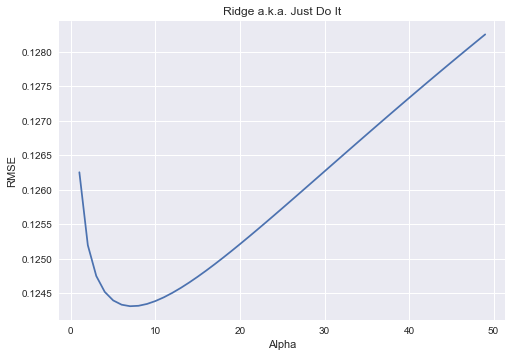

In [16]:
sns.set_style("darkgrid")
plt.plot(ridge_alphas, ridge_rmse_cv)
plt.title("Ridge a.k.a. Just Do It")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.show()

In [17]:
min_rmse_cv = np.min(ridge_rmse_cv)
bool_arr = np.array(ridge_rmse_cv) == min_rmse_cv
ridge_alphas[bool_arr]

array([7])

## 上傳

In [18]:
ridge = Ridge(alpha = ridge_alphas[bool_arr])
ridge.fit(X_train, y_train)
y_hat = ridge.predict(X_test)
y_hat = np.expm1(y_hat)
Id = test.Id
my_solution = pd.DataFrame(y_hat, Id, columns = ["SalePrice"])
my_solution.to_csv("my_solution.csv", index_label = ["Id"])

## Titanic: Machine Learning from Disaster

In [19]:
train_url = "https://storage.googleapis.com/py_ml_datasets/titanic/train.csv"
test_url = "https://storage.googleapis.com/py_ml_datasets/titanic/test.csv"
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 特徵工程

- 填補遺漏值
- 數值分箱
- One-hot Encoding

In [21]:
def fe_cabin(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def fe_fare(df):
    median = df.Fare.median()
    df.Fare = df.Fare.fillna(median)
    return df

def fe_embarked(df):
    df.Embarked = df.Embarked.fillna("S")
    return df

def fe_name(df):
    df['last_name'] = df.Name.apply(lambda x: x.split(' ')[0])
    df.last_name = df.last_name.apply(lambda x: x[:-1])
    df['name_prefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def fe_family(df):
    df['family_size'] = df.Parch + df.SibSp + 1
    return df

In [22]:
all_data = pd.concat([
    train.drop(["Survived"], axis = 1),
    test
], axis = 0)

all_data = fe_cabin(all_data)
all_data = fe_fare(all_data)
all_data = fe_embarked(all_data)
all_data = fe_name(all_data)
all_data = fe_family(all_data)

In [23]:
all_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
last_name        0
name_prefix      0
family_size      0
dtype: int64

In [24]:
def fe_age(df):
    age_df = df[['Age', 'Pclass','Sex', 'Fare', 'last_name', 'name_prefix', 'family_size']]
    age_df = pd.get_dummies(age_df)
    known_age = age_df.loc[df.Age.notnull()]
    unknown_age = age_df.loc[df.Age.isnull()]
    y = known_age.values[:, 0]
    X = known_age.iloc[:, 1:].values
    rmses = []
    alphas = [0.05, 0.1, 0.5, 1, 5, 10, 30, 50, 75, 100]
    for alpha in alphas:
        ridge = Ridge(alpha = alpha)
        ridge.fit(X, y)
        mse = cross_val_score(ridge, X, y, cv = 10, scoring = 'neg_mean_squared_error')
        rmse = np.mean((-mse)**0.5)
        rmses.append(rmse)
    min_rmse = np.min(rmses)
    rmse_bool = np.array(rmses) == min_rmse
    good_alpha = np.array(alphas)[rmse_bool]
    ridge = Ridge(alpha = good_alpha)
    ridge.fit(X, y)
    X_fit = unknown_age.iloc[:, 1:]
    predicted_ages = ridge.predict(X_fit)
    predicted_ages = np.where(predicted_ages <= df.Age.min(), 0, predicted_ages)
    predicted_ages = np.where(predicted_ages >= df.Age.max(), df.Age.max(), predicted_ages)
    df.loc[(df.Age.isnull()), 'Age'] = predicted_ages 
    return df

all_data = fe_age(all_data)

In [25]:
print(all_data.isnull().sum())
all_data.head()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
last_name      0
name_prefix    0
family_size    0
dtype: int64


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,last_name,name_prefix,family_size
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S,Braund,Mr.,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Cumings,Mrs.,2
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S,Heikkinen,Miss.,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Futrelle,Mrs.,2
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S,Allen,Mr.,1


In [26]:
all_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,family_size
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,2.294882,29.487388,0.498854,0.385027,33.281086,1.883881
std,378.020061,0.837836,13.443539,1.041658,0.865560,51.741500,1.583639
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800,1.000000
50%,655.000000,3.000000,28.736754,0.000000,0.000000,14.454200,1.000000
75%,982.000000,3.000000,37.000000,1.000000,0.000000,31.275000,2.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,11.000000


In [27]:
def bin_age(df):
    bins = (-1, 5, 12, 18, 25, 35, 60, 130)
    group_names = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels = group_names)
    df['age_binned'] = categories
    return df

def get_qtr(arr):
    qtr_1 = np.percentile(arr, 25)
    qtr_2 = np.percentile(arr, 50)
    qtr_3 = np.percentile(arr, 75)
    qtr_4 = np.max(arr)
    return qtr_1, qtr_2, qtr_3, qtr_4

def bin_fare(df, qtr_1, qtr_2, qtr_3, qtr_4):
    bins = (-1, qtr_1, qtr_2, qtr_3, qtr_4)
    group_names = ['1st_quartile', '2nd_quartile', '3rd_quartile', '4th_quartile']
    categories = pd.cut(df.Fare, bins, labels = group_names)
    df['fare_binned'] = categories
    return df

In [28]:
qtr_1, qtr_2, qtr_3, qtr_4 = get_qtr(all_data.Fare.values)

all_data = bin_age(all_data)
all_data = bin_fare(all_data, qtr_1, qtr_2, qtr_3, qtr_4)
all_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
last_name      0
name_prefix    0
family_size    0
age_binned     0
fare_binned    0
dtype: int64

In [29]:
all_data = all_data.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Age', 'Fare', 'last_name'], axis = 1)
all_data.head()

,Pclass,Sex,Embarked,name_prefix,family_size,age_binned,fare_binned
0,3,male,S,Mr.,2,Student,1st_quartile
1,1,female,C,Mrs.,2,Adult,4th_quartile
2,3,female,S,Miss.,1,Young Adult,2nd_quartile
3,1,female,S,Mrs.,2,Young Adult,4th_quartile
4,3,male,S,Mr.,1,Young Adult,2nd_quartile


In [30]:
all_data = pd.get_dummies(all_data)
X_train = all_data.values[:train.shape[0], :]
X_test = all_data.values[train.shape[0]:, :]
y_train = train['Survived'].values

## 隨機森林

In [31]:
forest = RandomForestClassifier()

parameters = {'n_estimators': [50, 100, 200, 300], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [5, 10, 15, 20], 
              'min_samples_split': [2, 5, 10, 15, 20]
             }
acc_scorer = make_scorer(accuracy_score)
grid = GridSearchCV(forest, parameters, scoring = acc_scorer)
grid = grid.fit(X_train, y_train)
print(grid.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [32]:
forest = grid.best_estimator_
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

PassengerId = test["PassengerId"].values.astype(int)
my_solution = pd.DataFrame(y_hat, PassengerId, columns = ["Survived"])
my_solution.to_csv("my_solution.csv", index_label = ["PassengerId"])